In [1]:
#!pip install datasets

In [2]:
## Please install torch and datasets
import torch
from torchvision.transforms import functional as t
import torch.nn.functional as f
from datasets import load_dataset
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
## Loading our dataset
ds = load_dataset("ylecun/mnist")

In [4]:
## Data splits

X_train_p = ds["train"]["image"]
Y_train = ds["train"]["label"]
X_test_p = ds["test"]["image"]
Y_test = ds["test"]["label"]

In [5]:
## PIL to Tensors

X_train = [t.pil_to_tensor(x) for x in X_train_p]
X_test = [t.pil_to_tensor(x) for x in X_test_p]
X_train = torch.stack(X_train).to(device)
X_test = torch.stack(X_test).to(device)
print(X_train.shape, X_test.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


In [6]:
## Fixing the shape

X_train = X_train.view(-1, 28, 28)
X_test = X_test.view(-1, 28, 28)
print(X_train.shape, X_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [7]:
## Making labels into tensors

Y_train = torch.tensor(Y_train).to(device)
Y_test = torch.tensor(Y_test).to(device)

In [8]:
## Flattening the image as DNN takes flat tensor as input

X_train = X_train.view(-1, 784).float() / 255.0
X_test = X_test.view(-1, 784).float() / 255.0
print(X_train.shape, X_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


In [9]:
class Linear():
  def __init__(self, input_dims, output_dims, B=True, last=False):
    self.training = True
    self.W = (torch.randn(input_dims, output_dims) * (5/3) / (input_dims**0.5)).to(device) if not last else (torch.randn(input_dims, output_dims) * (5/3) / (input_dims**0.5) * 0.1).to(device)
    if B: self.B = torch.randn(output_dims).to(device) if not last else (torch.randn(output_dims) * 0.1).to(device)
    else: self.B = torch.tensor([]).to(device)

  def __call__(self, x):
    if not torch.equal(self.B, torch.tensor([]).to(device)): self.result = x@self.W + self.B
    else: self.result = x@self.W
    return self.result

  def parameters(self):
    if not torch.equal(self.B, torch.tensor([]).to(device)):
        return [self.W, self.B]
    else:
        return [self.W]


class Tanh():
  def __init__(self):
    self.training = True
    return None

  def __call__(self, x):
    self.result = torch.tanh(x)
    return self.result

  def parameters(self):
    return []

class Dropout():
  def __init__(self, batch_size, output_dims, rate=0.9):
    self.training = True
    self.rate = rate
    self.factor = (torch.rand(batch_size, output_dims) < self.rate).int().to(device)
    return None

  def __call__(self, x):
    if self.training: self.result = x * self.factor
    else: self.result = x
    return self.result

  def parameters(self):
    return []




In [10]:
n1 = 512
n2 = 256
n3 = 128
n4 = 10
batch_size = 60000

layers = [
    #Linear(784, n1), Tanh(), Dropout(batch_size, n1),
#    Linear(n1, n2), Tanh(), Dropout(batch_size, n2),
#    Linear(n2, n3), Tanh(), Dropout(batch_size, n3),
    Linear(784, 10, last=True, B=False),
]

params = [p for layer in layers for p in layer.parameters()]
numparams = 0
for p in params:
    p.requires_grad = True
    numparams += p.numel()
print(numparams)

7840


In [11]:
## Training
iters = 4000
alpha = 0.008

for i in range(iters):
    # Forward Pass
    for layer in layers:
      layer.training = True

    x = X_train
    for layer in layers:
      x = layer(x)

    # Loss
    L = f.cross_entropy(x, Y_train)

    # Calculating Gradient
    for layer in layers:
      layer.result.retain_grad() # This stores grad of layers like Tanh that have no params to update

    for p in params:
        p.grad = None

    L.backward()

    # Weight Update
    for p in params:
        p.data += -alpha * p.grad

    if i % (iters/20) == 0:
        print(L)


tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(1.3106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4544, device='cuda:0', grad_fn=

layer 0, Linear: mean 0.00010187674342887476, std: 0.0586085170507431, saturated: 0.0%


Text(0.5, 1.0, 'Weight Distribution')

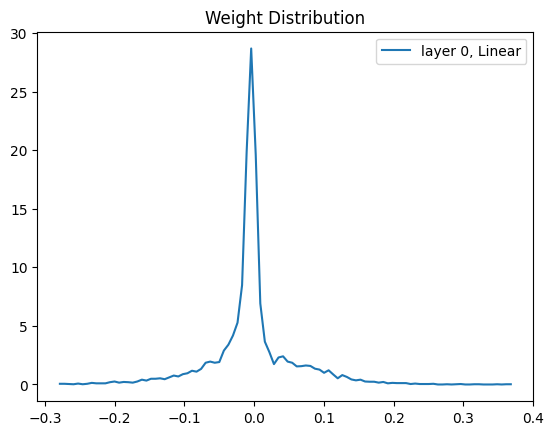

In [12]:
## Plotting Layer Parameters
# Let's try to make sure they're small (-1 t 1)
# If they're large, then w*x will be large, which after passing through tanh
# will become clipped to 1. Consequently, it will be difficult to evaluate the
# impact of varying w on the final output of the neuron. This is called the
# vanishing gradient problem. It can be shown mathematically as well.

k=-1
legends = []
for layer in layers:
  if isinstance(layer, Linear):
    k+=1
    result = layer.W
    print(f'layer {k}, {layer.__class__.__name__}: mean {result.mean()}, std: {result.std()}, saturated: {(result.abs() > 0.97).float().mean()*100}%' )
    y, x = torch.histogram(result.cpu(), density=True)
    plt.plot(x[:-1].detach(), y.detach())
    legends.append(f'layer {k}, {layer.__class__.__name__}')

plt.legend(legends)
plt.title('Weight Distribution')

Text(0.5, 1.0, 'Activation Distribution')

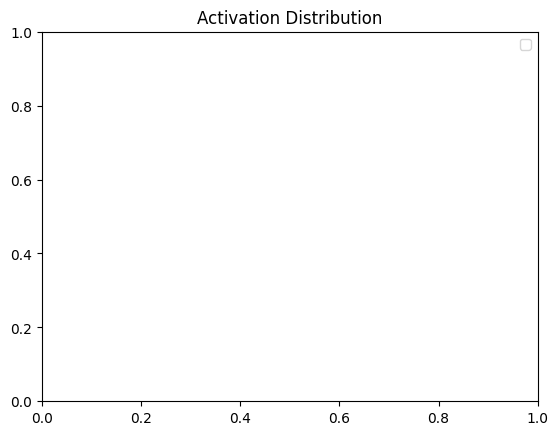

In [13]:
## Plotting Activations
# Ideal: Not too many activation outputs should be on either side of the curve
# because those indicate loss of information
# We want mean to be around 0
# Standard deviation to be around 0.67
# Saturation to be as low as possible.

k=-1
legends = []
for layer in layers:
  if isinstance(layer, Tanh):
    k+=1
    result = layer.result
    print(f'layer {k}, {layer.__class__.__name__}: mean {result.mean()}, std: {result.std()}, saturated: {(result.abs() > 0.97).float().mean()*100}%' )
    y, x = torch.histogram(result.cpu(), density=True)
    plt.plot(x[:-1].detach(), y.detach())
    legends.append(f'layer {k}, {layer.__class__.__name__}')


plt.legend(legends)
plt.title('Activation Distribution')

Text(0.5, 1.0, 'Gradient Distribution for Activations')

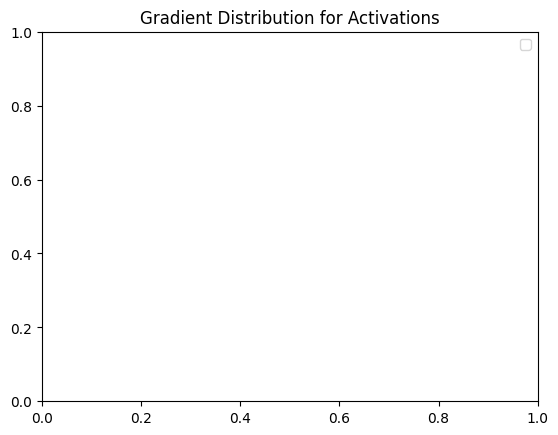

In [14]:
## Gradient Distribution for Activations

# TODO: Write notes on how this should look

k=-1
legends = []
for layer in layers:
  if isinstance(layer, Tanh):
    k+=1
    result = layer.result.grad
    print(f'layer {k}, {layer.__class__.__name__}: mean {result.mean()}, std: {result.std()}, saturated: {(result.abs() > 0.97).float().mean()*100}%' )
    y, x = torch.histogram(result.cpu(), density=True)
    plt.plot(x[:-1].detach(), y.detach())
    legends.append(f'layer {k}, {layer.__class__.__name__}')

plt.legend(legends)
plt.title('Gradient Distribution for Activations')

layer 0, Linear: mean 2.5985560925256834e-11, std: 0.000637808523606509, saturated: 0.0%


Text(0.5, 1.0, 'Gradient Distribution for Weights')

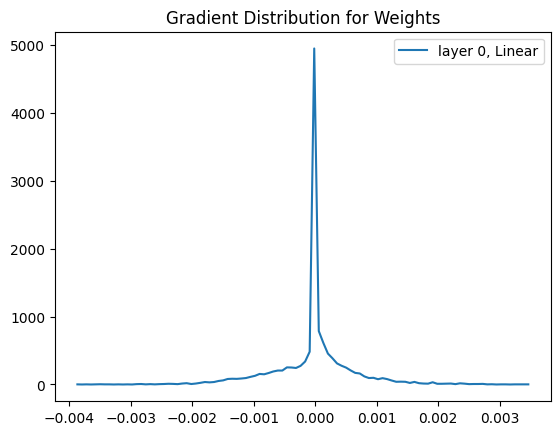

In [15]:
## Gradient Distribution for Params

# TODO: Write notes on how this should look

k=-1
legends = []
for layer in layers:
  if isinstance(layer, Linear):
    k+=1
    result = layer.W.grad
    print(f'layer {k}, {layer.__class__.__name__}: mean {result.mean()}, std: {result.std()}, saturated: {(result.abs() > 0.97).float().mean()*100}%' )
    y, x = torch.histogram(result.cpu(), density=True)
    plt.plot(x[:-1].detach(), y.detach())
    legends.append(f'layer {k}, {layer.__class__.__name__}')

plt.legend(legends)
plt.title('Gradient Distribution for Weights')

In [16]:
## Plotting Dead Neurons

# Count how many Tanh layers we have
tanh_layers = [layer for layer in layers if isinstance(layer, Tanh)]
num_layers = len(tanh_layers)

# Create a figure with subplots (adjust rows/columns as needed)
fig, axes = plt.subplots(1, num_layers, figsize=(15, 3))

# If there's only one layer, axes won't be an array, so we wrap it
if num_layers == 1:
    axes = [axes]

# Plot each layer's activations
for i, layer in enumerate([layer for layer in layers if isinstance(layer, Tanh)]):
    activations = layer.result.cpu().detach()
    axes[i].imshow(activations[:10] > 0.99, cmap='gray', aspect='auto')
    axes[i].set_title(f'Layer {i} Dead Neurons')
    axes[i].set_xlabel('Neuron Index')
    axes[i].set_ylabel('Sample Index')

plt.tight_layout()
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1500x300 with 0 Axes>

In [17]:
def accuracy(X, Y):
    for layer in layers:
      layer.training=False
    # Forward
    x = X
    for layer in layers:
      x = layer(x)
    probs = f.softmax(x, 1)
    answers = x.argmax(1)
    c = 0
    for a, y in zip(answers, Y):
        if a==y: c+=1
    return c / answers.shape[0] * 100

def loss(X, Y):
    x = X
    for layer in layers:
      x = layer(x)
    return f.cross_entropy(x, Y)


print(f"train accuracy: {accuracy(X_train, Y_train)} | test accuracy: {accuracy(X_test, Y_test)}")
print(f"train loss: {loss(X_train, Y_train)} | test loss: {loss(X_test, Y_test)}")

train accuracy: 88.54833333333333 | test accuracy: 89.35
train loss: 0.43699052929878235 | test loss: 0.4154093265533447


tensor([4], device='cuda:0')


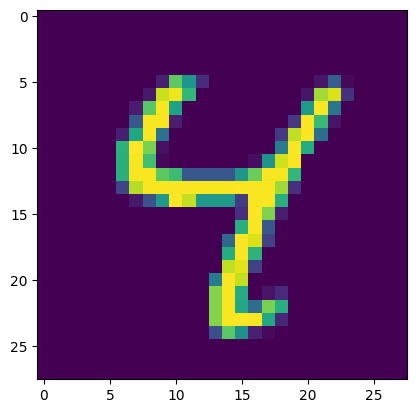

In [ ]:
import matplotlib.pyplot as plt

sample = torch.stack([X_test[6]])
plt.imshow(sample.view(28, 28).cpu())
x = sample
for layer in layers:
  x = layer(x)
probs = f.softmax(x, 1)

answer = x.argmax(1)
print(answer)